# Initialization

In [ ]:
from google.colab import drive
from google.colab import files

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-tqdm

In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import glob
from scipy.signal import fftconvolve,firwin, freqz,lfilter,lfilter_zi,firls
import tensorflow as tf
from tqdm.notebook import tnrange

In [ ]:
electrodes = ['FP1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3',' FC1', 'C1', 'C3','C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1','P1','P3', 'P5', 'P7', 'P9', 'RO7', 'PO3', 'O1', 'Iz','Oz','POz', 'Pz', 'CPZ', 'FPZ', 'FP2', 'AF8', 'AF4', 'AFZ','FZ', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz','Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10','PO8', 'PO4', 'O2','EMG1','EMG2','EMG3','EMG4']
electrodes.reverse()

In [ ]:
# path = "/content/drive/MyDrive/EEG-GAN/Dataset/cho_et_al_data/raw"
path = "/content/drive/My Drive/Colab Notebooks/EEG-GAN/Dataset/cho_et_al_data/raw/"
files = glob.glob(path + '/*.mat')
# files

In [ ]:
#@title Preprocessing Functions
def bandpass_firls(xn, lowcut2,lowcut1, highcut1, highcut2, fs):
    nyq = 0.5 * fs
    ntaps = fs if fs%2==1 else fs+1
    b = firls(ntaps, [0 ,lowcut2,lowcut1, highcut1, highcut2,nyq], [0,0,1,1,0,0] ,fs=fs)
    a=1
    zi = lfilter_zi(b, a)
    z, _ = lfilter(b, a, xn,zi=zi*xn[0])
    return z

def band_separate(data, fs, ntaps):
    delta = bandpass_firls(data,ntaps,0.1,0.5, 4, 5, fs)
    theta = bandpass_firls(data,ntaps,3.5,4, 8, 8.5, fs)
    alpha = bandpass_firls(data,ntaps,7,8, 12, 13, fs)
    sigma = bandpass_firls(data,ntaps,11.5,12, 16, 16.5, fs)
    beta = bandpass_firls(data,ntaps,15.5,16, 30, 30.5, fs)
    return delta, theta, alpha, sigma, beta

def filter_alpha(data, Fs):
  d = []
  for i in range (data.shape[0]):
    alpha = bandpass_firls(data[i], 7,8, 12, 13, Fs)
    d.append(alpha)
  data = np.stack(d, axis  = 0)
  return data

In [ ]:
#@title Dataset Functions
def struct2dict(mat):
  data = dict()
  key = list(mat.keys())[-1]
  for i in range(len(mat[key][0,0])):
    data[mat[key][0,0].dtype.descr[i][0]] = mat[key][0,0][i]
  return data

def channel_normalize(data, axis):
  mean = np.expand_dims(data.mean(axis = axis), axis = axis)
  diff = np.expand_dims(data.max(axis = axis)- data.min(axis = axis), axis = axis)
  data = (data - mean)/diff
  return data

def create_dataset(files):
  data = []
  labels=[]
  for i in tnrange(len(files)):
    mat = sio.loadmat(files[i])
    mat = struct2dict(mat)
    d1 = mat['movement_left']
    d1 = filter_alpha(d1, 512)
    d1 = channel_normalize(d1, axis = 1)
    d1 = d1.T.reshape(-1, 2560, 68)
    d2 = mat['movement_right']
    d2 = filter_alpha(d2, 512)
    d2 = channel_normalize(d2, axis = 1)
    d2 = d2.T.reshape(-1, 2560, 68)
    data.append(d1)
    data.append(d2)
    l1 = np.zeros((d1.shape[0],1))
    l2 = np.ones((d1.shape[0],1))
    labels.append(l1)
    labels.append(l2)
  data = np.concatenate(data)
  labels = np.concatenate(labels)
  return data, labels

In [ ]:
#@title Visualizaton Functions
def channel_normalize(data, axis):
  mean = np.expand_dims(data.mean(axis = axis), axis = axis)
  diff = np.expand_dims(data.max(axis = axis)- data.min(axis = axis), axis = axis)
  data = (data - mean)/diff
  return data

def normalize(data):
  mean = data.mean()
  diff = data.max()- data.min()
  data = (data - mean)/diff
  return data


def show_eeg_signal(Xf, ch_names, fs, seconds, sensitivity, spacing, mode = 'norm'):
  Xf = Xf[:,:seconds*fs].T
  if mode == 'max':
    Xf = normalize(Xf)*sensitivity
  else:
    Xf = channel_normalize(Xf, axis = 1)*sensitivity
  ch_len = Xf.shape[1]
  print(ch_len)
  t = np.arange(seconds*fs)
  plt.figure(figsize=(5*seconds,ch_len))
  plt.plot(t,Xf+np.arange(-int(np.ceil(ch_len/2)),int(np.floor(ch_len/2)))*spacing)
  plt.xlim([t[0],t[-1]])
  plt.xlabel('time (sec)')
  plt.yticks(np.arange(-int(np.ceil(ch_len/2)),int(np.floor(ch_len/2)))*spacing,ch_names)
  plt.grid()
  plt.title('Xf: 14 channel - EEG Signal')
  plt.show()

In [ ]:
data, labels = create_dataset(files)

  0%|          | 0/52 [00:00<?, ?it/s]

# WGAN Conv1D

In [ ]:
#@title Import
import tensorflow as tf
from tensorflow.keras.metrics import Mean
from tensorflow.keras.losses import mse
from tensorflow.keras.models import load_model, save_model

import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, LeakyReLU, Conv1D, MaxPooling1D, Activation, Input, UpSampling2D, BatchNormalization, Lambda, Concatenate, Layer, Embedding, Conv1DTranspose
from tensorflow.keras.models import Model, load_model
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import os
from matplotlib import pyplot as plt

In [ ]:
#@title Discriminator-Generator Model
# discriminator block

def conv_block(
    x,
    filters,
    activation,
    kernel_size=3,
    strides= 1,
    padding="valid",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5
):
    x = Conv1D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_discriminator_model(trial_shape, num_classes):

    k_size = trial_shape[0]//(96*2)
    s_size = trial_shape[0]//(96*2)

    kernel_size = 6 # (1, 32)
    strides = 6 # (1, 8)

    last_kernel_size = 6  # (32, 1)
    last_strides = 6  #(1, 1) #(8, 1)
    
#     print(f'k_size - {k_size}, s_size - {s_size}, ')
    
    img_input = Input(shape=trial_shape)
    in_label = Input(shape=(num_classes,))

    label_embedding = Embedding(num_classes, 10)(in_label)
    label_embedding = Flatten()(label_embedding)
    label_embedding = Dense(5, use_bias=False)(label_embedding)
    n_nodes = np.prod(trial_shape) 

    label_embedding = Dense(n_nodes)(label_embedding)
    label_embedding = Reshape(target_shape=(trial_shape))(label_embedding)

    inputs = Concatenate()([img_input, label_embedding]) 

    x = inputs
    x = conv_block(
        x,
        32,
        kernel_size=kernel_size,
        strides=strides,
        use_bn=True,
        use_bias=True,
        activation=LeakyReLU(0.2),
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        64,
        kernel_size=kernel_size,
        strides=strides,
        use_bn=True,
        activation=LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=kernel_size,
        strides=strides,
        use_bn=True,
        activation=LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=last_kernel_size,
        strides=last_strides,
        use_bn=True,
        activation=LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )

    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)

    d_model = Model([img_input, in_label], x, name="discriminator")
    return d_model


# generator block
def upsample_block(
    x,
    filters,
    activation,
    kernel_size,
    strides=1,
    padding="valid",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = Conv1DTranspose(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_generator_model(noise_dim, trial_shape, num_classes):

#     dummy kernel_sizes to get good starting shape
    k_size = (2 * trial_shape[1])//16
    s_size = trial_shape[1]//16
    
    intermediate_time_dim = ((trial_shape[0]-k_size)//s_size)+1

    kernel_size_1 = 4
    kernel_size_2 = 4
    strides_1 = 4
    
    starting_shape = (160, 1)
#     print(f'strides_1 - {strides_1}, kernel_size_1 - {kernel_size_1}, kernel_size_2 - {kernel_size_2}, intermediate_time_dim - {intermediate_time_dim}, starting_shape - {starting_shape}')
    
    noise = Input(shape=(noise_dim,)) 
    in_label = Input(shape=(num_classes,))

    label_embedding = Embedding(num_classes, 10)(in_label)
    label_embedding = Flatten()(label_embedding)

    label_embedding = Dense(noise_dim, use_bias=False)(label_embedding)
    label_embedding = Reshape(target_shape=(noise_dim, ))(label_embedding)

    inputs = Concatenate()([noise, label_embedding]) 
    inputs = Dense(10, use_bias=False)(inputs)

    x = Dense(np.prod(starting_shape), use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Reshape(starting_shape)(x)
    x = upsample_block(
        x,
        256,
        LeakyReLU(0.2),
        kernel_size=kernel_size_1,
        strides= strides_1, 
        use_bias=True,
        use_bn=True,
        use_dropout=True,
    )
    
    # x = upsample_block(
    #     x,
    #     32,
    #     LeakyReLU(0.2),
    #     kernel_size=kernel_size_2,
    #     strides=strides_1,
    #     use_bias=True,
    #     use_bn=True,
    #     use_dropout=True,
    # )
    
    x = upsample_block(
        x, 68, LeakyReLU(0.2), kernel_size=kernel_size_2, strides=strides_1, use_bias=True, use_bn=True, 
        padding="same")

    g_model = Model([noise, in_label], x, name="generator")
    return g_model

In [ ]:
#@title Discriminator-Generator Model 2
# discriminator block

def conv_block(
    x,
    filters,
    activation,
    kernel_size=3,
    strides= 1,
    padding="valid",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5
):
    x = Conv1D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_discriminator_model(trial_shape, num_classes):
    
#     print(f'k_size - {k_size}, s_size - {s_size}, ')
    
    img_input = Input(shape=trial_shape)
    in_label = Input(shape=(num_classes,))

    label_embedding = Embedding(num_classes, 10)(in_label)
    label_embedding = Flatten()(label_embedding)
    label_embedding = Dense(5, use_bias=False)(label_embedding)
    n_nodes = np.prod(trial_shape) 

    label_embedding = Dense(n_nodes)(label_embedding)
    label_embedding = Reshape(target_shape=(trial_shape))(label_embedding)

    inputs = Concatenate()([img_input, label_embedding]) 

    x = inputs
    x = conv_block(
        x,
        64,
        kernel_size=3,
        strides=1,
        use_bn=True,
        padding = 'same',
        use_bias=True,
        activation=LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        64,
        kernel_size=3,
        strides=2,
        use_bn=True,
        padding = 'same',
        use_bias=True,
        activation=LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=3,
        strides=2,
        use_bn=True,
        padding = 'same',
        use_bias=True,
        activation=LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=3,
        strides=2,
        use_bn=True,
        padding = 'same',
        use_bias=True,
        activation=LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=3,
        strides=2,
        use_bn=True,
        padding = 'same',
        use_bias=True,
        activation=LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=5,
        strides=2,
        use_bn=True,
        padding = 'same',
        use_bias=True,
        activation=LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        1,
        kernel_size=1,
        strides=1,
        use_bn=False,
        padding = 'same',
        use_bias=False,
        activation=LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
       
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)

    d_model = Model([img_input, in_label], x, name="discriminator")
    return d_model


# generator block
def upsample_block(
    x,
    filters,
    activation,
    kernel_size,
    strides=1,
    padding="valid",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = Conv1DTranspose(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_generator_model(noise_dim, trial_shape, num_classes):


    
    starting_shape = (160, 1)
#     print(f'strides_1 - {strides_1}, kernel_size_1 - {kernel_size_1}, kernel_size_2 - {kernel_size_2}, intermediate_time_dim - {intermediate_time_dim}, starting_shape - {starting_shape}')
    
    noise = Input(shape=(noise_dim,)) 
    in_label = Input(shape=(num_classes,))

    label_embedding = Embedding(num_classes, 10)(in_label)
    label_embedding = Flatten()(label_embedding)

    label_embedding = Dense(noise_dim, use_bias=False)(label_embedding)
    label_embedding = Reshape(target_shape=(noise_dim, ))(label_embedding)

    inputs = Concatenate()([noise, label_embedding]) 
    inputs = Dense(10, use_bias=False)(inputs)

    x = Dense(np.prod(starting_shape), use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Reshape(starting_shape)(x)
    x = upsample_block(
        x,
        128,
        LeakyReLU(0.2),
        kernel_size=1,
        strides= 1, 
        padding = 'same',
        use_bias=False,
        use_bn=False,
        use_dropout=False,
    )
    x = upsample_block(
        x,
        256,
        LeakyReLU(0.2),
        kernel_size=5,
        strides= 2, 
        padding = 'same',
        use_bias=False,
        use_bn=False,
        use_dropout=False,
    )

    x = upsample_block(
        x,
        128,
        LeakyReLU(0.2),
        kernel_size=3,
        strides= 2, 
        padding = 'same',
        use_bias=False,
        use_bn=False,
        use_dropout=False,
    )
    x = upsample_block(
        x,
        128,
        LeakyReLU(0.2),
        kernel_size=3,
        strides= 2, 
        padding = 'same',
        use_bias=False,
        use_bn=False,
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        LeakyReLU(0.2),
        kernel_size=3,
        strides= 2, 
        padding = 'same',
        use_bias=False,
        use_bn=False,
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        LeakyReLU(0.2),
        kernel_size=3,
        strides= 2, 
        padding = 'same',
        use_bias=False,
        use_bn=False,
        use_dropout=False,
    )
    x = upsample_block(
        x,
        68,
        LeakyReLU(0.2),
        kernel_size=3,
        strides= 1, 
        padding = 'same',
        use_bias=False,
        use_bn=False,
        use_dropout=False,
    )

    g_model = Model([noise, in_label], x, name="generator")
    return g_model

In [ ]:
data.shape

(2912, 2560, 68)

In [ ]:
all_labels = np.unique(labels)
num_classes = len(all_labels)
trial_shape = data[0].shape
batch_size = 16
latent_dim = 160
d_model = get_discriminator_model(trial_shape, num_classes)
print(d_model.summary())
# print(latent_dim)
g_model = get_generator_model(latent_dim, trial_shape, num_classes)
print(g_model.summary())

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 2, 10)        20          ['input_2[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 20)           0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 5)            100         ['flatten[0][0]']                
                                                                                      

In [ ]:
#@title Discriminator-Generator Model 3
# discriminator block

def conv_block(
    x,
    filters,
    activation,
    kernel_size=3,
    strides= 1,
    padding="valid",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5
):
    x = Conv1D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_discriminator_model(trial_shape, num_classes):
    
#     print(f'k_size - {k_size}, s_size - {s_size}, ')
    
    img_input = Input(shape=trial_shape)
    in_label = Input(shape=(num_classes,))

    label_embedding = Embedding(num_classes, 10)(in_label)
    label_embedding = Flatten()(label_embedding)
    label_embedding = Dense(5, use_bias=False)(label_embedding)
    n_nodes = np.prod(trial_shape) 

    label_embedding = Dense(n_nodes)(label_embedding)
    label_embedding = Reshape(target_shape=(trial_shape))(label_embedding)

    inputs = Concatenate()([img_input, label_embedding]) 

    x = inputs
    x = conv_block(
        x,
        64,
        kernel_size=3,
        strides=1,
        use_bn=True,
        padding = 'same',
        use_bias=True,
        activation=LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        64,
        kernel_size=3,
        strides=2,
        use_bn=True,
        padding = 'same',
        use_bias=True,
        activation=LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=3,
        strides=2,
        use_bn=True,
        padding = 'same',
        use_bias=True,
        activation=LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=3,
        strides=1,
        use_bn=True,
        padding = 'same',
        use_bias=True,
        activation=LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=3,
        strides=2,
        use_bn=True,
        padding = 'same',
        use_bias=True,
        activation=LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=5,
        strides=1,
        use_bn=True,
        padding = 'same',
        use_bias=True,
        activation=LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        1,
        kernel_size=1,
        strides=1,
        use_bn=False,
        padding = 'same',
        use_bias=False,
        activation=LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
       
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(1)(x)

    d_model = Model([img_input, in_label], x, name="discriminator")
    return d_model


# generator block
def upsample_block(
    x,
    filters,
    activation,
    kernel_size,
    strides=1,
    padding="valid",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = Conv1DTranspose(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def get_generator_model(noise_dim, trial_shape, num_classes):


    
    starting_shape = (noise_dim, 1)
#     print(f'strides_1 - {strides_1}, kernel_size_1 - {kernel_size_1}, kernel_size_2 - {kernel_size_2}, intermediate_time_dim - {intermediate_time_dim}, starting_shape - {starting_shape}')
    
    noise = Input(shape=(noise_dim,)) 
    in_label = Input(shape=(num_classes,))

    label_embedding = Embedding(num_classes, 10)(in_label)
    label_embedding = Flatten()(label_embedding)

    label_embedding = Dense(noise_dim, use_bias=False)(label_embedding)
    label_embedding = Reshape(target_shape=(noise_dim, ))(label_embedding)

    inputs = Concatenate()([noise, label_embedding]) 
    inputs = Dense(10, use_bias=False)(inputs)

    x = Dense(np.prod(starting_shape), use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Reshape(starting_shape)(x)
    x = upsample_block(
        x,
        128,
        LeakyReLU(0.2),
        kernel_size=1,
        strides= 1, 
        padding = 'same',
        use_bias=False,
        use_bn=False,
        use_dropout=False,
    )
    x = upsample_block(
        x,
        256,
        LeakyReLU(0.2),
        kernel_size=5,
        strides= 1, 
        padding = 'same',
        use_bias=False,
        use_bn=False,
        use_dropout=False,
    )

    x = upsample_block(
        x,
        128,
        LeakyReLU(0.2),
        kernel_size=3,
        strides= 1, 
        padding = 'same',
        use_bias=False,
        use_bn=False,
        use_dropout=False,
    )
    x = upsample_block(
        x,
        128,
        LeakyReLU(0.2),
        kernel_size=3,
        strides= 2, 
        padding = 'same',
        use_bias=False,
        use_bn=False,
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        LeakyReLU(0.2),
        kernel_size=3,
        strides= 2, 
        padding = 'same',
        use_bias=False,
        use_bn=False,
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        LeakyReLU(0.2),
        kernel_size=3,
        strides= 2, 
        padding = 'same',
        use_bias=False,
        use_bn=False,
        use_dropout=False,
    )
    x = upsample_block(
        x,
        68,
        LeakyReLU(0.2),
        kernel_size=3,
        strides= 1, 
        padding = 'same',
        use_bias=False,
        use_bn=False,
        use_dropout=False,
    )

    g_model = Model([noise, in_label], x, name="generator")
    return g_model

In [ ]:
#@title GAN-Functions
class WGAN(Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        data_mean,
        data_std,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight
        self.data_mean = data_mean
        self.data_std = data_std

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images, labels):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        # class_mean = params_map
        # class_std = params_map
        alpha = tf.random.normal([batch_size, 1, 1], 0, self.data_mean)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch([interpolated, labels])
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator([interpolated, labels], training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated, labels])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images_):
        if isinstance(real_images_, tuple):
            real_images = real_images_[0][0]
            real_labels = real_images_[0][1]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator([random_latent_vectors, real_labels], training=False)  # should training for the gen be True here? - training=False
                # Get the logits for the fake images
                fake_logits = self.discriminator([fake_images, real_labels], training=True)
                # Get the logits for the real images
                real_logits = self.discriminator([real_images, real_labels], training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images, real_labels)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight
            
            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )
        
        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator([random_latent_vectors, real_labels], training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator([generated_images, real_labels], training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        
        return {"d_loss": d_loss, "g_loss": g_loss}


# class GANMonitor(Callback):
#     def __init__(self, all_labels, num_classes, num_img=15, latent_dim=128):
#         self.num_img = num_img
#         self.latent_dim = latent_dim
#         self.all_labels = all_labels
#         self.num_classes = num_classes

#     def on_epoch_end(self, epoch, logs=None):

#         if epoch % 100 != 0:
#           return
          
#         random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
#         random_labels = tf.random.uniform((self.num_img, ), minval=0, maxval=self.num_classes, dtype=tf.dtypes.int32)
#         random_labels_encoded = tf.keras.utils.to_categorical(random_labels, self.num_classes)
#         generated_images = self.model.generator([random_latent_vectors, random_labels_encoded])
#         # generated_images = (generated_images * 127.5) + 127.5 - seems only necessary for imgs

#         for i in range(self.num_img):
#             img = generated_images[i].numpy()
#             img = array_to_img(img)
#             img.save(f"{master_path}/generated_img_epoch_{epoch}_{self.all_labels[random_labels[i]]}_.png")


# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return tf.sqrt(tf.math.squared_difference(fake_loss, real_loss))


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


def construct_gan(noise_dim, trial_shape, num_classes, data_mean, data_std):
  # Instantiate the optimizer for both networks
  # (learning_rate=0.0002, beta_1=0.5 are recommended)
  generator_optimizer = Adam(
      learning_rate=0.0002, beta_1=0.5, beta_2=0.9
  )
  discriminator_optimizer = Adam(
      learning_rate=0.0002, beta_1=0.5, beta_2=0.9
  )

  d_model = get_discriminator_model(trial_shape, num_classes)
  d_model.summary()

  g_model = get_generator_model(noise_dim, trial_shape, num_classes)
  g_model.summary()

  # Instantiate the WGAN model.
  wgan = WGAN(
      discriminator=d_model,
      generator=g_model,
      latent_dim=noise_dim,
      data_mean=data_mean, 
      data_std=data_std,
      discriminator_extra_steps=3,
  )

  # Compile the WGAN model.
  wgan.compile(
      d_optimizer=discriminator_optimizer,
      g_optimizer=generator_optimizer,
      g_loss_fn=generator_loss,
      d_loss_fn=discriminator_loss,
  )

  return wgan


def encode_labels(y, num_classes):
    encoder = LabelEncoder()
    encoder.fit(y)
    y_enc = encoder.transform(y)
    
    return to_categorical(y_enc, num_classes), encoder

def plot_gend_data(real_data, labels, synth_data, n_to_show=12):

  assert len(real_data) == len(labels) 
  assert len(labels) == len(synth_data)
  
  num_present = len(labels)
  n_to_show = np.min((n_to_show, num_present))
  random_picks = np.random.randint(0, num_present, n_to_show)

  real_plot = real_data[random_picks]
  synth_plot = synth_data[random_picks]
  labels_plot = labels[random_picks]
  
  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
    img = real_plot[i].squeeze()
    sub = fig.add_subplot(1, n_to_show, i+1)
    sub.axis('off')  
    sub.imshow(img, extent=[0,100,0,1], aspect='auto')
    sub.set_title(labels[i])

  # print('\n')

  for i in range(n_to_show):
    img = synth_plot[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')  
    sub.imshow(img, extent=[0,100,0,1], aspect='auto')
    sub.set_title(labels[i])
def generate_data_from_gan(subject, mapped_data_labels, n_gen, master_path, data_paths, latent_dim=128):

  generator_path = os.path.join(master_path, data_paths['saved_models'], data_paths['gans'], subject, 'generator') 
  model = load_model(generator_path)

  labels = list(mapped_data_labels.keys())
  synth_data_labels = {}

  random_num_select = 10
  real_plot_data = []
  real_plot_labels = []

  synth_plot_data = []
  synth_plot_labels = []

  for label in labels:
    num_classes = len(labels)
    num_gen = round(n_gen/num_classes)

    # generate num_gen samples
    synth_latent_points = np.random.randn(num_gen, latent_dim)
    synth_labels = np.asarray([1 if label == lab else 0 for lab in labels]) 
    synth_labels_encoded = np.asarray([synth_labels for i in range(num_gen)])

    # generate images
    synth_data = model.predict([synth_latent_points, synth_labels_encoded])
    data_gendfor_label = np.squeeze(synth_data)
    synth_data_labels[label] = data_gendfor_label

    data_for_label = mapped_data_labels[label]
    random_picks = data_for_label[np.random.randint(0, len(data_for_label), random_num_select)]
    real_plot_data.append(random_picks)
    real_plot_labels.append([label] * random_num_select)

    synth_plot_data.append(synth_data[:random_num_select])

  real_plot_data = np.concatenate(real_plot_data)
  real_plot_labels = np.concatenate(real_plot_labels)

  synth_plot_data = np.concatenate(synth_plot_data)
  
  # # plot data
  # plot_gend_data(real_plot_data, real_plot_labels, synth_plot_data)
  return synth_data_labels


def augment_data(data, labels, with_noise=False, n_augs = 1000):
  # augment train by adding replicas with noise - use std to be sure you're not corrupting the data with std of 1. e.g cho's was /1e-6.
  # check the range, mean... of data 
  
  data = np.squeeze(data)

  data_shape = data.shape
  new_data = data[:]
  new_y_labels = labels[:]

  while len(new_data) < n_augs:
    aug_data = data[:]
    new_data = np.concatenate((new_data, aug_data))
    new_y_labels = np.concatenate((new_y_labels, labels)) 

  new_data = np.expand_dims(new_data, -1)
  return new_data, new_y_labels


def train_gan(data, labels, save_path, epochs=500):
  
    # augment train by adding replicas 
    #data, labels = augment_data(data, labels, n_augs = 1000) 

    all_labels = np.unique(labels)
    num_classes = len(all_labels)
    labels_encoded, encoder = encode_labels(labels, num_classes)
    
    data_mean = np.mean(data)
    data_std = np.std(data)
    
    # parameters
    trial_shape = data[0].shape
    batch_size = 16
    latent_dim = 160

    # `GANMonitor` callbacks.
    # cbk = GANMonitor(all_labels, num_classes, num_img=5, latent_dim=latent_dim)
    
    wgan = construct_gan(latent_dim, trial_shape, num_classes, data_mean, data_std)
    history = wgan.fit([data, labels_encoded], batch_size=batch_size, epochs=epochs) 

    discriminator_save_path = os.path.join(save_path, 'discriminator')
    generator_save_path = os.path.join(save_path, 'generator')
    
    if not os.path.exists(generator_save_path):
      os.makedirs(generator_save_path)
    if not os.path.exists(discriminator_save_path):
      os.makedirs(discriminator_save_path)
      
    wgan.generator.save(generator_save_path, save_format='tf')
    wgan.discriminator.save(discriminator_save_path, save_format='tf')

    # plot history
    dloss = history.history['d_loss']
    gloss = history.history['g_loss']
    epochs = list(range(len(dloss)))

    plt.plot(epochs, dloss, 'r--', epochs, gloss, 'g--')
    plt.legend(['Critic Loss', 'Gen Loss' ])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.savefig(f'{save_path}/losses.png')
    plt.close('all')

In [ ]:
save_path = '/content/drive/MyDrive/EEG-GAN/Model_Saves/Saved_Model_6/'

In [ ]:
#@title Train GAN
all_labels = np.unique(labels)
num_classes = len(all_labels)
labels_encoded, encoder = encode_labels(labels, num_classes)

data_mean = np.mean(data)
data_std = np.std(data)

# parameters
trial_shape = data[0].shape
batch_size = 16
latent_dim = 320
epochs = 200 
# `GANMonitor` callbacks.
# cbk = GANMonitor(all_labels, num_classes, num_img=5, latent_dim=latent_dim)

wgan = construct_gan(latent_dim, trial_shape, num_classes, data_mean, data_std)
history = wgan.fit([data, labels_encoded], batch_size=batch_size, epochs=epochs) 

discriminator_save_path = os.path.join(save_path, 'discriminator')
generator_save_path = os.path.join(save_path, 'generator')

if not os.path.exists(generator_save_path):
  os.makedirs(generator_save_path)
if not os.path.exists(discriminator_save_path):
  os.makedirs(discriminator_save_path)
  
wgan.generator.save(generator_save_path, save_format='tf')
wgan.discriminator.save(discriminator_save_path, save_format='tf')

# plot history
dloss = history.history['d_loss']
gloss = history.history['g_loss']
epochs = list(range(len(dloss)))

plt.plot(epochs, dloss, 'r--', epochs, gloss, 'g--')
plt.legend(['Critic Loss', 'Gen Loss' ])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.savefig(f'{save_path}/losses.png')
plt.close('all')

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 2, 10)        20          ['input_6[0][0]']                
                                                                                                  
 flatten_3 (Flatten)            (None, 20)           0           ['embedding_2[0][0]']            
                                                                                                  
 dense_6 (Dense)                (None, 5)            100         ['flatten_3[0][0]']              
                                                                                      

KeyboardInterrupt: ignored

In [ ]:
model = load_model('/content/drive/MyDrive/EEG-GAN/Model_Saves/Saved_Model_4/generator')
synth_latent_points = np.random.randn(10, 160)
synth_labels = np.zeros((10,2))
preds = model.predict([synth_latent_points, synth_labels])

1/1 [==============================] - 2s 2s/step


# FFT-GAN

In [ ]:
data = data[:,:,0]

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(100).batch(8)

In [ ]:
#@title Training
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np


# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define the shape of the noise vector
def dense_block(x, output_shape, dropout = 0.2, act = tf.keras.activations.gelu):
  x = Dense(output_shape)(x)
  x = BatchNormalization()(x)
  x = Dropout(dropout)(x)
  x = act(x)
  return x

# Define the generator model
def make_generator_model(latent_dim):
    input = Input(shape=(latent_dim,)) 
    x = dense_block(input, 320)
    x = dense_block(x, 1280)
    x = dense_block(x, 2560)
    x = dense_block(x, 5120, act = tf.keras.activations.tanh)
    x_real, x_imag = tf.split(x, num_or_size_splits=2, axis=-1)
    x = tf.complex(x_real, x_imag)
    x = tf.signal.ifft(x)
    x = tf.math.real(x)
    g_model = Model(input, x, name="generator")
    return g_model

# Define the discriminator model
def make_discriminator_model(signal_shape):
    input = Input(shape=(signal_shape,)) 
    z = tf.zeros_like(input)
    x = tf.complex(input, z)
    x = tf.signal.fft(x)
    x = tf.concat([tf.math.real(x),tf.math.imag(x)], axis = -1)
    x = dense_block(x, 2560)
    x = dense_block(x, 1280)
    x = dense_block(x, 320)
    x = dense_block(x, 160) 
    x = dense_block(x, 1, act = tf.keras.activations.sigmoid) 
    d_model = Model(input, x, name="discriminator")
    return d_model

# Define the generator loss
def generator_loss(fake_output):
    return tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)

# Define the discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Define the optimizer for both generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Define the batch size and number of epochs
batch_size = 8
epochs = 50
latent_dim = 160
# Create the generator and discriminator models
generator = make_generator_model(latent_dim)
discriminator = make_discriminator_model(2560)

# Define the GAN model
def make_gan_model(generator, discriminator):
    # Freeze the discriminator layers
    discriminator.trainable = False

    # Define the GAN model as the generator followed by the discriminator
    gan_input = layers.Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    gan_model = Model(gan_input, gan_output)

    # Compile the GAN model with the generator loss
    gan_model.compile(loss=generator_loss, optimizer=generator_optimizer)

    return gan_model

# Create the GAN model
gan_model = make_gan_model(generator, discriminator)

# Load dataset and preprocess as needed
# ...

# Define function to generate samples from the generator during training
def generate_and_save_samples(model, epoch, latent_dim):
    # Generate random noise samples
    noise = tf.random.normal([16, latent_dim])

    # Generate matrix samples from noise
    generated_samples = model.predict(noise)

    # Rescale generated samples from [-1, 1] to [0, 1]
    generated_samples = (generated_samples + 1) / 2.0

    # Save generated samples as a .npy file
    np.save(f"generated_samples_epoch_{epoch}.npy", generated_samples)


def train_gan(generator, discriminator, gan_model, dataset, epochs, batch_size, latent_dim):
    for epoch in range(epochs):
        for batch in dataset:
            # Train the discriminator
            noise = tf.random.normal([batch_size, latent_dim])
            generator.trainable = False
            generated_samples = generator(noise)
            real_samples = batch
            with tf.GradientTape() as tape:
                real_output = discriminator(real_samples)
                fake_output = discriminator(generated_samples)
                d_loss = tf.math.reduce_mean(discriminator_loss(real_output, fake_output))
            grads = tape.gradient(d_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

            # Train the generator
            noise = tf.random.normal([batch_size, latent_dim])
            generator.trainable = True
            with tf.GradientTape() as tape:
                generated_samples = generator(noise)
                fake_output = discriminator(generated_samples)
                g_loss = tf.math.reduce_mean(generator_loss(fake_output))*1e6

            grads = tape.gradient(g_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

        # Generate and save samples every 50 epochs
        if epoch % 50 == 0:
            generate_and_save_samples(generator, epoch, latent_dim)

        print(f"Epoch {epoch+1}/{epochs}: generator loss {g_loss}, discriminator loss {d_loss}")

# Train the GAN model
train_gan(generator, discriminator, gan_model, dataset, epochs, batch_size, latent_dim)


1/1 [==============================] - 0s 143ms/step
Epoch 1/50: generator loss 9.626206519897096e-06, discriminator loss 12.970787048339844
Epoch 2/50: generator loss 8.419227924605366e-06, discriminator loss 13.582805633544922
Epoch 3/50: generator loss 2.9802379231114173e-06, discriminator loss 14.622814178466797
Epoch 4/50: generator loss 2.5779054340091534e-06, discriminator loss 14.17248821258545
Epoch 5/50: generator loss 2.0265611055947375e-06, discriminator loss 16.656444549560547
Epoch 6/50: generator loss 2.1904809273110004e-06, discriminator loss 16.032808303833008
Epoch 7/50: generator loss 4.425711267685983e-06, discriminator loss 17.065279006958008
Epoch 8/50: generator loss 9.983784821088193e-07, discriminator loss 15.542339324951172
Epoch 9/50: generator loss 1.1026868378394283e-06, discriminator loss 16.061246871948242
Epoch 10/50: generator loss 3.4272676430191495e-07, discriminator loss 16.660236358642578
Epoch 11/50: generator loss 3.278256031080673e-07, discrimina

KeyboardInterrupt: ignored

In [ ]:
noise = tf.random.normal([8, 160])
preds = generator.predict(noise)

1/1 [==============================] - 0s 23ms/step


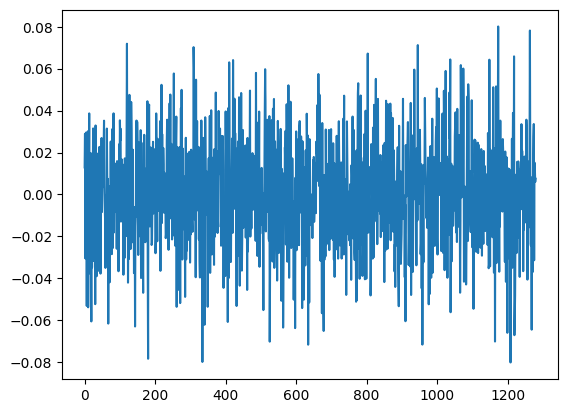

In [ ]:
plt.plot(preds[0][0:1280])

# Visualization

In [ ]:
preds[0].min()

-0.076476745

68


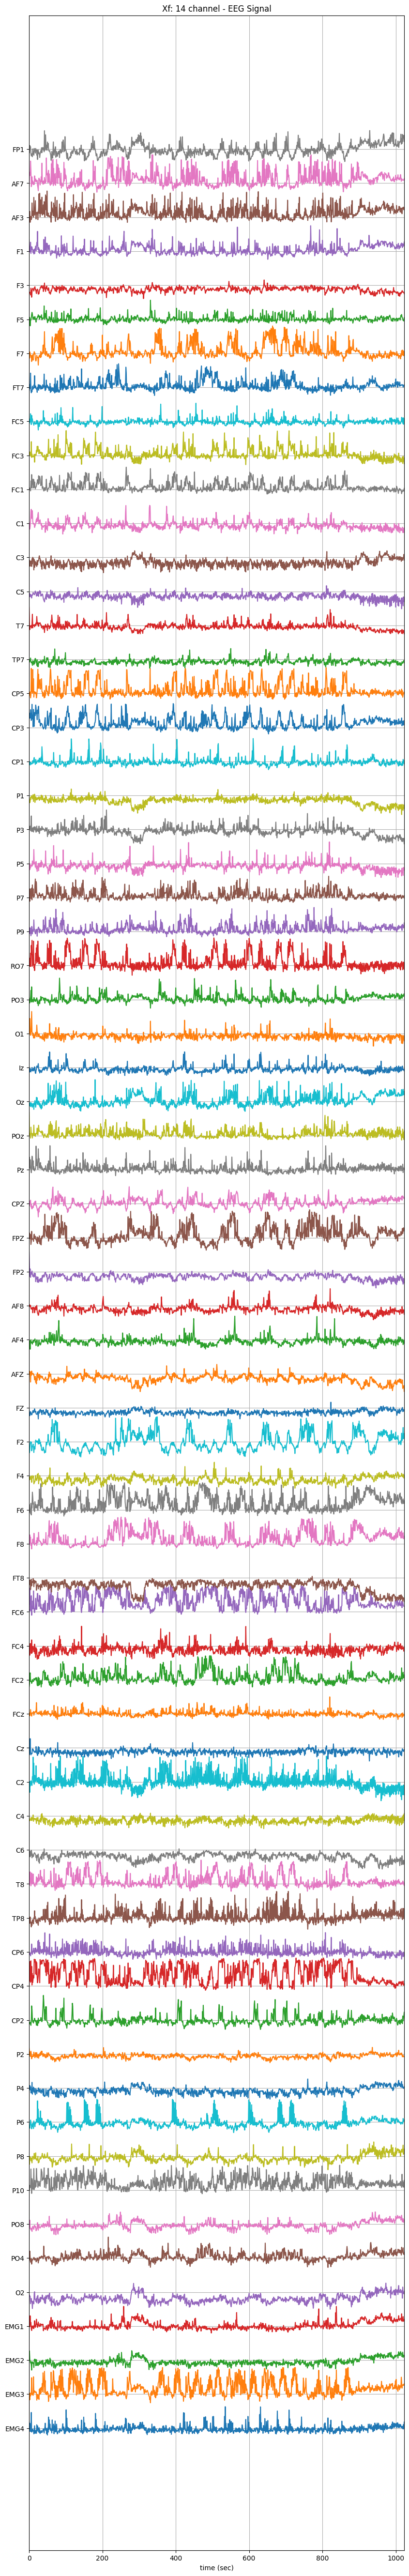

In [ ]:
show_eeg_signal(preds[0].T, electrodes, 512, 3, 4 ,4)

# Scratch Code

In [ ]:
fft = tf.signal.fft(data[0,:,0])

In [ ]:
x = tf.signal.ifft(fft*2)

In [ ]:
y = tf.complex(tf.math.real(x), tf.math.imag(x))

In [ ]:
tf.math.real(x)

<tf.Tensor: shape=(2560,), dtype=float32, numpy=
array([0.30200896, 0.29571068, 0.2907466 , ..., 0.2256546 , 0.21002427,
       0.20206228], dtype=float32)>

In [ ]:
data = data[:,:, 0]

In [ ]:
for batch in dataset: 
  print(batch.shape)

(16, 2560)
(16, 2560)
(16, 2560)
(8, 2560)
